# Cascade FWM Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from Whitley_Stroud import *

## Constant parameters

In [2]:
DeltaT = 30e-9  # integration time window
Gamma1 = 6.066
Gamma2 = 0.666
Delta = 40.0

lw = 1.4
pump1 = 0.450
pump2 = 15

## Frequency Detuning

In [3]:
def signal_f(x, parvals):
    return (
        parvals["N"]
        * parvals["etas"]
        * single_lw(
            x,
            parvals["Delta"],
            parvals["Oma"],
            parvals["Omb"],
            parvals["x0"],
            parvals["lw"],
        )
        + parvals["dc_s"]
    )


def idler_f(x, parvals):
    return (
        parvals["N"]
        * parvals["etai"]
        * single_lw(
            x,
            parvals["Delta"],
            parvals["Oma"],
            parvals["Omb"],
            parvals["x0"],
            parvals["lw"],
        )
        + parvals["dc_i"]
    )


def pair_f(x, parvals):
    return (
        parvals["N"]
        * parvals["etai"]
        * parvals["etas"]
        * pairs_lw(
            x,
            parvals["Delta"],
            parvals["Oma"],
            parvals["Omb"],
            parvals["x0"],
            parvals["lw"],
        )
    )


def eff_s_f(x, parvals):
    return pair_f(x, parvals) / signal_f(x, parvals)


def eff_i_f(x, parvals):
    return pair_f(x, parvals) / idler_f(x, parvals)

In [4]:
parvals = dict(
    N=1000,
    etas=0.17,
    etai=0.22,
    Delta=60,
    Oma=8.8,
    Omb=6,
    x0=-2,
    lw=2.9,
    dc_s=0,
    dc_i=0,
)

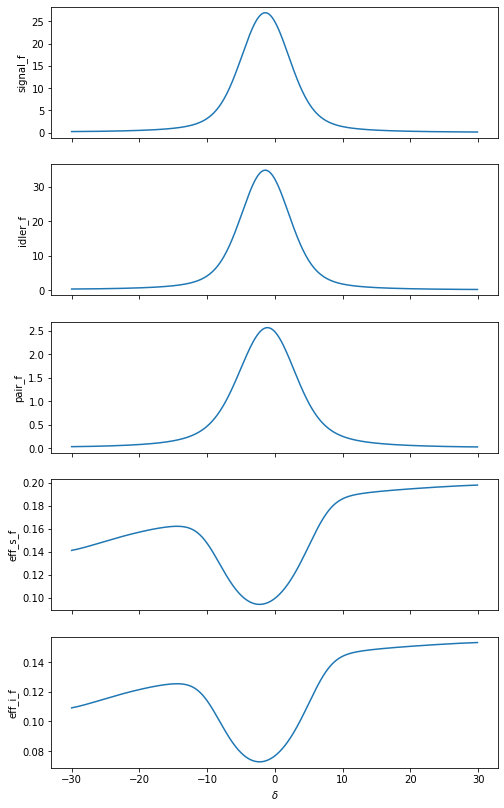

In [5]:
funcs = [signal_f, idler_f, pair_f, eff_s_f, eff_i_f]
f, axs = plt.subplots(len(funcs), 1, sharex=True, figsize=(8, 14))

o_vec = np.arange(-30, 30, 0.1)

for fn, ax in zip(funcs, axs):
    ax.plot(o_vec, fn(o_vec, parvals))
    ax.set_ylabel(fn.__name__)
plt.xlabel("$\delta$");

## Pump Power

In [6]:
from scipy.ndimage import convolve1d

In [7]:
freq = np.linspace(-10, 10, 101)


def signal_p(p1: float, p2: float, parvals: dict) -> float:
    Oma = parvals["ma"] * np.sqrt(p1)
    Omb = parvals["mb"] * np.sqrt(p2)
    rf = s_33(Oma, Omb, Gamma1, Gamma2, parvals["delta"] + freq, parvals["Delta"])
    r = np.sum(convolve1d(rf, laser(freq, parvals["lw"]), mode="nearest"))
    offset = parvals["scatter_rate_s"] * p1
    return parvals["N"] * parvals["etas"] * r + offset


def signal_p_v(p2: np.array, p1: float, parvals: dict) -> np.array:
    return np.array([signal_p(p1, k, parvals) for k in p2])


def idler_p(p1: float, p2: float, parvals: dict) -> float:
    Oma = parvals["ma"] * np.sqrt(p1)
    Omb = parvals["mb"] * np.sqrt(p2)
    rf = s_33(Oma, Omb, Gamma1, Gamma2, parvals["delta"] + freq, parvals["Delta"])
    r = np.sum(convolve1d(rf, laser(freq, parvals["lw"]), mode="nearest"))
    offset = parvals["scatter_rate_i"] * p1
    return parvals["N"] * parvals["etai"] * r + offset


def idler_p_v(p2: np.array, p1: float, parvals: dict) -> np.array:
    return np.array([idler_p(p1, k, parvals) for k in p2])


def pairs_p(p1: float, p2: float, parvals: dict) -> float:
    Oma = parvals["ma"] * np.sqrt(p1)
    Omb = parvals["mb"] * np.sqrt(p2)
    rf = (
        np.abs(
            s_31(Oma, Omb, Gamma1, Gamma2, parvals["delta"] + freq, parvals["Delta"])
        )
        ** 2
    )
    r = np.sum(convolve1d(rf, laser(freq, parvals["lw"]), mode="nearest"))

    return parvals["N"] * parvals["etas"] * parvals["etai"] * np.array(r)


def pairs_p_v(p2: np.array, p1: float, parvals: dict) -> np.array:
    return np.array([pairs_p(p1, k, parvals) for k in p2])


def eff_s_p_v(p2: np.array, p1: float, parvals: dict) -> np.array:
    return pairs_p_v(p2, p1, parvals) / signal_p_v(p2, p1, parvals)


def eff_i_p_v(p2: np.array, p1: float, parvals: dict) -> np.array:
    return pairs_p_v(p2, p1, parvals) / idler_p_v(p2, p1, parvals)

In [8]:
parvals = dict(
    N=1000,
    delta=-3,
    Delta=60,
    x0=-2,
    lw=2.9,
    scatter_rate_s=0,
    scatter_rate_i=0,
    ma=5,
    mb=5,
    etas=0.17,
    etai=0.22,
)

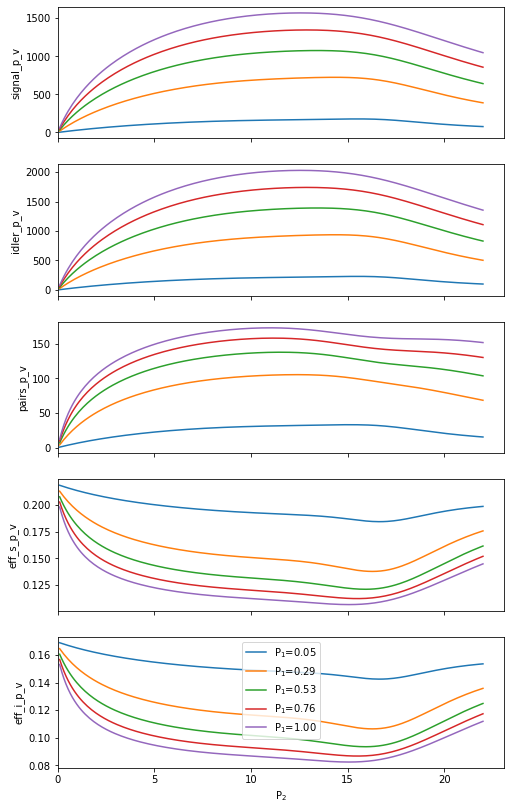

In [9]:
f, axes = plt.subplots(len(funcs), 1, figsize=(8, 14), sharex=True)
funcs = [signal_p_v, idler_p_v, pairs_p_v, eff_s_p_v, eff_i_p_v]

p1_v = np.linspace(0.05, 1, 5)
p2_v = np.linspace(0.1, 22, 200)

for fn, ax in zip(funcs, axes):
    for p1 in p1_v:
        ax.plot(p2_v, fn(p2_v, p1, parvals), label=f'P$_1$={p1:.2f}')
    ax.set_ylabel(fn.__name__)
plt.xlabel("P$_2$")
plt.legend()
plt.xlim(0);